In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
torch.manual_seed(42)
import matplotlib.pyplot as plt
from PIL import Image
import skimage
np.random.seed(42)
torch.manual_seed(42)

In [166]:
import cv2

In [2]:
class relu_mlp(nn.Module):
  def __init__(self, neurons, h_layers):
    super(relu_mlp, self).__init__()
    self.neurons = neurons
    self.h_layers = h_layers

    self.layers = nn.ModuleList()
    self.layers.append(nn.Linear(2,neurons))
    for i in range (h_layers-1):
      self.layers.append(nn.Linear(neurons,neurons))
    self.layers.append(nn.Linear(neurons, 1))
  
  def forward (self,x):
    for layer in self.layers[:-1]:
      x = F.relu(layer(x))
    x = self.layers[-1](x)
    return x

In [3]:
class siren_mlp(nn.Module):
  def __init__(self, neurons, h_layers, omega):
    super(siren_mlp, self).__init__()
    self.neurons = neurons
    self.h_layers = h_layers
    self.omega = omega

    self.layers = nn.ModuleList()
    self.layers.append(nn.Linear(2, neurons))
    for i in range(h_layers-1):
      self.layers.append(nn.Linear(neurons, neurons))
    self.layers.append(nn.Linear(neurons,1))

    nn.init.uniform_(self.layers[0].weight,-1/2,1/2)
    for layer in self.layers[1:]:
      nn.init.uniform_(layer.weight,-np.sqrt(6/neurons)/omega, np.sqrt(6/neurons)/omega)
  
  def forward (self, x):
    for layer in self.layers[:-1]:
      x = torch.sin(layer(x))
    x = self.layers[-1](x)
    return x

In [4]:
def coordinates (n):
  # Create an empty list to store the tuples
  tuples = []

  # Iterate over all x and y values from 0 to 512
  for x in range(n):
      for y in range(n):
          # Append the current tuple to the list
          tuples.append([x, y])

  # Convert the list to a NumPy array if desired
  tuples_array = np.array(tuples)
  return tuples_array

In [5]:
img = Image.fromarray(skimage.data.camera())        

In [6]:
img = img.resize((256,256))

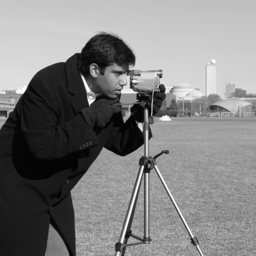

In [7]:
img

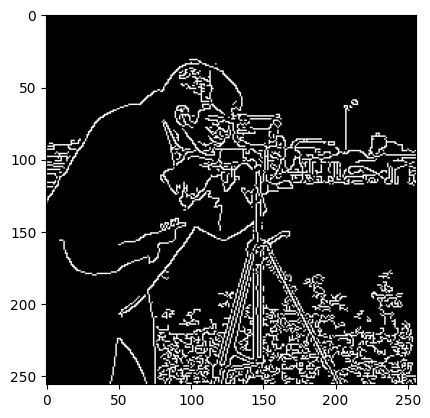

In [175]:
img_gradient = cv2.Canny(image_array.astype('uint8'),50,150)
plt.imshow(img_gradient, cmap = "gray")

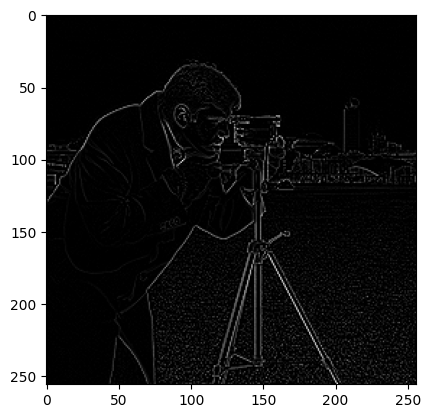

In [176]:
img_laplacian = cv2.Laplacian(image_array.astype('uint8'),50,150)
plt.imshow(img_laplacian, cmap = "gray")

In [8]:
image_array = np.asarray(img)
image_array_rescaled = (image_array-127.5)/127.5

In [15]:
from tqdm import tqdm

In [18]:
device = 'cuda'

In [19]:
torch.cuda.is_available()

True

In [29]:
relu_model = relu_mlp(256,4).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(relu_model.parameters(), lr=0.0001)

In [21]:
X = coordinates(256)
y = image_array_rescaled.reshape(-1)

In [28]:
relu_psnr = []

In [53]:
num_epochs = 1000
for e in tqdm(range(num_epochs)):
  y_pred_train = relu_model(torch.from_numpy(X.astype('float32')).to(device)).squeeze()
  loss = criterion(y_pred_train, torch.from_numpy(y.astype('float32')).to(device)) # loss is a tensor which stores the current value of train loss
  relu_psnr.append(20 * np.log10(1.0 / np.sqrt(loss.item())))

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if e % 100 == 0:
    print(f"Epoch [{e}/{num_epochs}], Loss: {loss.item():.4f}") # loss.item() gives the numerical value stored in loss
  if e == num_epochs-1:
    print(f"Epoch [{e}/{num_epochs}], Loss: {loss.item():.4f}") # loss.item() gives the numerical value stored in loss

  0%|          | 4/1000 [00:00<00:34, 29.25it/s]

Epoch [0/1000], Loss: 0.0365


 11%|█         | 107/1000 [00:02<00:23, 37.41it/s]

Epoch [100/1000], Loss: 0.0410


 21%|██        | 207/1000 [00:05<00:21, 36.91it/s]

Epoch [200/1000], Loss: 0.0450


 31%|███       | 307/1000 [00:08<00:18, 36.76it/s]

Epoch [300/1000], Loss: 0.0442


 41%|████      | 407/1000 [00:11<00:16, 36.71it/s]

Epoch [400/1000], Loss: 0.0369


 51%|█████     | 507/1000 [00:13<00:13, 36.39it/s]

Epoch [500/1000], Loss: 0.0450


 61%|██████    | 607/1000 [00:16<00:10, 36.05it/s]

Epoch [600/1000], Loss: 0.0354


 71%|███████   | 707/1000 [00:19<00:08, 36.14it/s]

Epoch [700/1000], Loss: 0.0339


 81%|████████  | 807/1000 [00:22<00:05, 35.91it/s]

Epoch [800/1000], Loss: 0.0410


 91%|█████████ | 907/1000 [00:24<00:02, 35.74it/s]

Epoch [900/1000], Loss: 0.0401


100%|██████████| 1000/1000 [00:27<00:00, 36.37it/s]

Epoch [999/1000], Loss: 0.0334


In [54]:
len(relu_psnr)

15000

In [193]:
y_preds = relu_model(torch.from_numpy(X.astype('float32')).to(device))

In [194]:
y_image_values = (y_preds.cpu().detach().numpy().reshape(256,256)*127.5)+127.5
y_image_values

array([[199.16913 , 199.48001 , 200.53897 , ..., 192.44939 , 192.54414 ,
        192.63914 ],
       [199.30054 , 199.44891 , 199.97467 , ..., 192.67886 , 192.77333 ,
        192.86752 ],
       [200.1918  , 200.50162 , 199.92038 , ..., 192.88538 , 192.9852  ,
        193.08499 ],
       ...,
       [ 19.530075,  19.823105,  20.195953, ..., 147.56229 , 147.74208 ,
        147.92177 ],
       [ 19.404945,  19.696907,  20.073761, ..., 147.4902  , 147.48143 ,
        147.66121 ],
       [ 19.279457,  19.570648,  19.95192 , ..., 147.5316  , 147.4029  ,
        147.401   ]], dtype=float32)

In [195]:
image_array

array([[199, 199, 200, ..., 190, 190, 190],
       [199, 199, 200, ..., 190, 190, 190],
       [200, 200, 199, ..., 191, 191, 191],
       ...,
       [ 25,  25,  24, ..., 136, 143, 118],
       [ 26,  25,  26, ..., 147, 154, 144],
       [ 25,  25,  25, ..., 146, 146, 151]], dtype=uint8)

In [196]:
y_image_values

array([[199.16913 , 199.48001 , 200.53897 , ..., 192.44939 , 192.54414 ,
        192.63914 ],
       [199.30054 , 199.44891 , 199.97467 , ..., 192.67886 , 192.77333 ,
        192.86752 ],
       [200.1918  , 200.50162 , 199.92038 , ..., 192.88538 , 192.9852  ,
        193.08499 ],
       ...,
       [ 19.530075,  19.823105,  20.195953, ..., 147.56229 , 147.74208 ,
        147.92177 ],
       [ 19.404945,  19.696907,  20.073761, ..., 147.4902  , 147.48143 ,
        147.66121 ],
       [ 19.279457,  19.570648,  19.95192 , ..., 147.5316  , 147.4029  ,
        147.401   ]], dtype=float32)

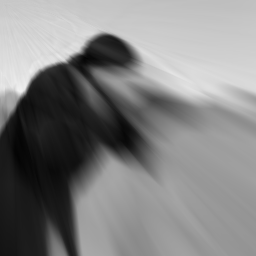

In [197]:
relu_img = Image.fromarray(y_image_values)
relu_img.show()

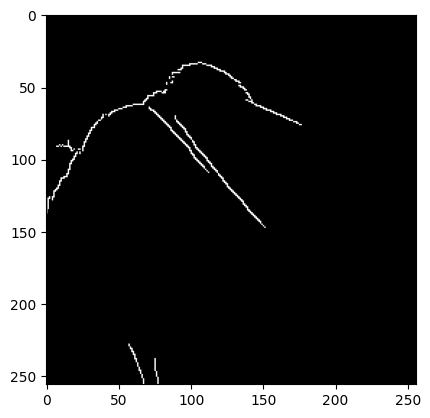

In [198]:
relu_img_gradient = cv2.Canny(y_image_values.astype('uint8'),50,150)
plt.imshow(relu_img_gradient, cmap = "gray")

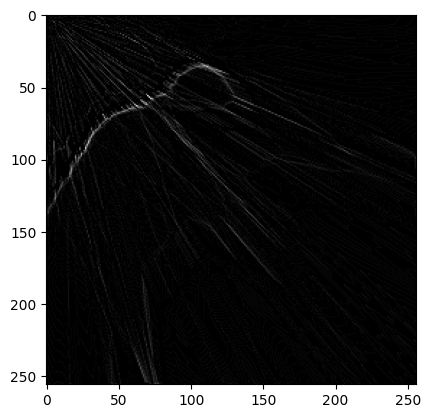

In [199]:
relu_img_laplacian = cv2.Laplacian(y_image_values.astype('uint8'),50,150)
plt.imshow(relu_img_laplacian, cmap = "gray")

In [61]:
siren_model = siren_mlp(256,4, 30).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(siren_model.parameters(), lr=0.0001)

In [62]:
siren_psnr = []

In [87]:
num_epochs = 1000
for e in tqdm(range(num_epochs)):
  y_pred_train = siren_model(torch.from_numpy(X.astype('float32')).to(device)).squeeze()
  loss = criterion(y_pred_train, torch.from_numpy(y.astype('float32')).to(device)) # loss is a tensor which stores the current value of train loss
  siren_psnr.append(20 * np.log10(1.0 / np.sqrt(loss.item())))

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if e % 100 == 0:
    print(f"Epoch [{e}/{num_epochs}], Loss: {loss.item():.4f}") # loss.item() gives the numerical value stored in loss
  if e == num_epochs-1:
    print(f"Epoch [{e}/{num_epochs}], Loss: {loss.item():.4f}") # loss.item() gives the numerical value stored in loss

  0%|          | 4/1000 [00:00<00:34, 28.52it/s]

Epoch [0/1000], Loss: 0.0076


 11%|█         | 107/1000 [00:03<00:26, 33.79it/s]

Epoch [100/1000], Loss: 0.0099


 21%|██        | 207/1000 [00:06<00:23, 33.66it/s]

Epoch [200/1000], Loss: 0.0073


 31%|███       | 307/1000 [00:09<00:21, 32.99it/s]

Epoch [300/1000], Loss: 0.0086


 41%|████      | 407/1000 [00:12<00:17, 32.97it/s]

Epoch [400/1000], Loss: 0.0073


 51%|█████     | 507/1000 [00:15<00:14, 33.08it/s]

Epoch [500/1000], Loss: 0.0072


 61%|██████    | 607/1000 [00:18<00:11, 33.13it/s]

Epoch [600/1000], Loss: 0.0079


 71%|███████   | 707/1000 [00:21<00:08, 32.66it/s]

Epoch [700/1000], Loss: 0.0082


 81%|████████  | 807/1000 [00:24<00:05, 32.36it/s]

Epoch [800/1000], Loss: 0.0074


 91%|█████████ | 907/1000 [00:27<00:02, 31.79it/s]

Epoch [900/1000], Loss: 0.0072


100%|██████████| 1000/1000 [00:30<00:00, 32.86it/s]

Epoch [999/1000], Loss: 0.0082


In [88]:
len(siren_psnr)

15000

In [200]:
y_preds = siren_model(torch.from_numpy(X.astype('float32')).to(device))

In [201]:
y_image_values = (y_preds.cpu().detach().numpy().reshape(256,256)*127.5)+127.5
y_image_values

array([[155.62805 , 175.93205 , 192.33629 , ..., 200.48346 , 196.657   ,
        194.67361 ],
       [171.77849 , 185.92905 , 198.16632 , ..., 201.21687 , 194.89862 ,
        191.08513 ],
       [183.3995  , 191.85529 , 201.24072 , ..., 200.00108 , 194.7381  ,
        191.4909  ],
       ...,
       [ 26.398933,  30.099045,  33.34015 , ..., 145.31268 , 137.5572  ,
        139.62993 ],
       [ 33.28154 ,  35.18589 ,  35.384644, ..., 144.3831  , 136.9088  ,
        143.4963  ],
       [ 29.256317,  27.402779,  27.578064, ..., 153.09895 , 146.36382 ,
        155.22186 ]], dtype=float32)

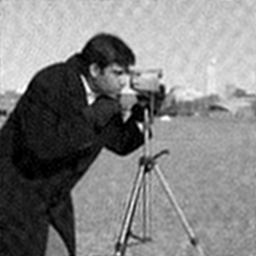

In [202]:
siren_img = Image.fromarray(y_image_values)
siren_img.show()

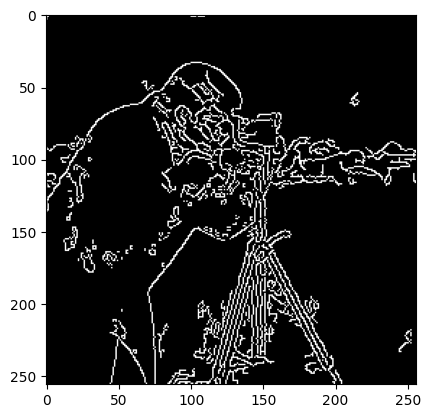

In [203]:
siren_img_gradient = cv2.Canny(y_image_values.astype('uint8'),50,150)
plt.imshow(siren_img_gradient, cmap = "gray")

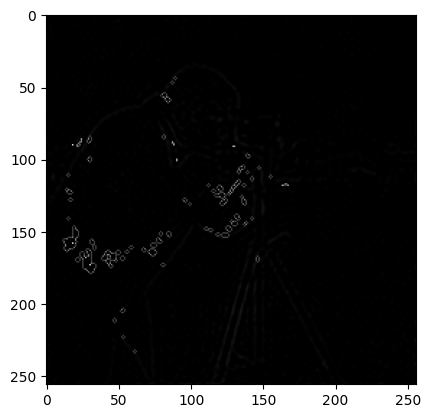

In [204]:
siren_img_laplacian = cv2.Laplacian(y_image_values.astype('uint8'),50,150)
plt.imshow(siren_img_laplacian, cmap = "gray")

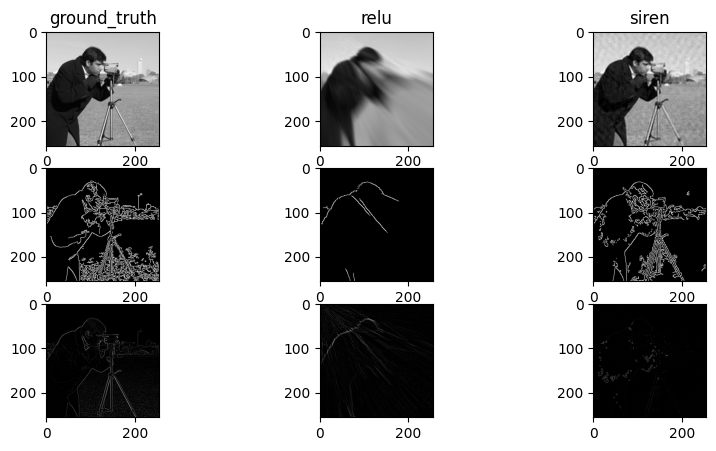

In [213]:
fig,ax = plt.subplots(3,3, figsize = (10,5))
ax[0,0].imshow(image_array, cmap = "gray")
ax[1,0].imshow(img_gradient, cmap = "gray")
ax[2,0].imshow(img_laplacian, cmap = "gray")
ax[0,1].imshow(relu_img, cmap = "gray")
ax[1,1].imshow(relu_img_gradient, cmap = "gray")
ax[2,1].imshow(relu_img_laplacian, cmap = "gray")
ax[0,2].imshow(siren_img, cmap = "gray")
ax[1,2].imshow(siren_img_gradient, cmap = "gray")
ax[2,2].imshow(siren_img_laplacian, cmap = "gray")
ax[0,0].set(title = 'ground_truth')
ax[0,1].set(title = 'relu')
ax[0,2].set(title = 'siren')
plt.show()

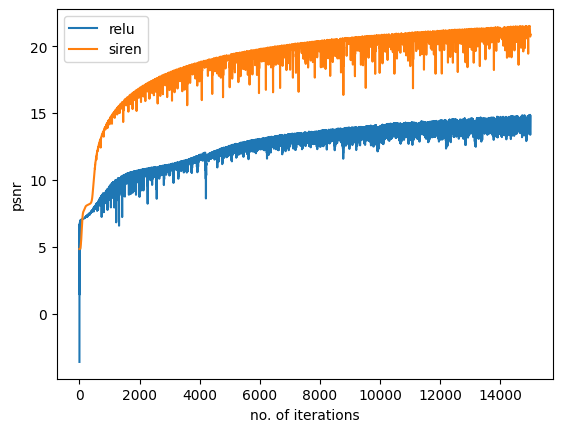

In [220]:
plt.xlabel('no. of iterations')
plt.ylabel('psnr')
plt.plot(range(15000), relu_psnr, label = 'relu')
plt.plot(range(15000), siren_psnr, label = 'siren')
plt.legend()
plt.show()